In [1]:
import tensorflow as tf
import numpy as np
import math
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('MNIST', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
print("- Size:Training-set: \t\t{}".format(len(data.train.labels)))
print("- Size:Test-set: \t\t{}".format(len(data.test.labels)))
print("- Size:Validation-set: \t\t{}".format(len(data.validation.labels)))

- Size:Training-set: 		55000
- Size:Test-set: 		10000
- Size:Validation-set: 		5000


In [4]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [5]:
img_size = 28
img_size_flat = img_size**2
image_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

In [6]:
def plot_img(images, cls_label, cls_pred=None):
    
    fig, axes = plt.subplots(1, 10, figsize=(15,15))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for idx, ax in enumerate(axes.flat):
        ax.imshow(images[idx].reshape(image_shape), cmap='binary')
        
        if cls_pred is None:
            label = "True: {0}".format(cls_label[idx])
        else:
            label = "True: {0}, Pred: {1}".format(cls_label[idx], cls_pred[idx])
        
        ax.set_xlabel(label)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

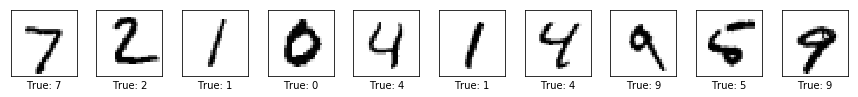

In [7]:
images = data.test.images[0:10]
cls_true = data.test.cls[0:10]
plot_img(images=images, cls_label=cls_true)

In [8]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [9]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [10]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [11]:
y_true_cls = tf.argmax(y_true, axis = 1)

In [12]:
filter_size1, num_filters1 = 5, 16
filter_size2, num_filters2 = 5, 36
fc_size = 128

In [13]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [14]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [15]:
def conv_layer(input, num_input_channels, filter_size, num_filters):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length = num_filters)
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1,1,1,1], padding=
                     'SAME', use_cudnn_on_gpu=True)
    
    layer += biases
    
    layer = tf.nn.max_pool(value=layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    layer = tf.nn.relu(layer)
    
    return layer, weights

In [16]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

In [17]:
def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer

In [18]:
layer_conv1, weight_conv1 = conv_layer(input=x_image, 
                                       num_input_channels=num_channels, 
                                      filter_size=filter_size1, 
                                      num_filters=num_filters1)

In [19]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [20]:
layer_conv2, weight_conv2 = conv_layer(input=layer_conv1, 
                                       num_input_channels=num_filters1, 
                                      filter_size=filter_size2, 
                                      num_filters=num_filters2)

In [21]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [22]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [23]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [24]:
num_features

1764

In [25]:
layer_fc1 = new_fc_layer(input=layer_flat, 
                        num_inputs=num_features,
                        num_outputs=fc_size,
                        use_relu=True)

In [26]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [27]:
layer_fc2 = new_fc_layer(input=layer_fc1, 
                        num_inputs=fc_size,
                        num_outputs=num_classes,
                        use_relu=False)

In [28]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [29]:
y_pred = tf.nn.softmax(layer_fc2)

In [30]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [31]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2, labels=y_true)

In [32]:
cost = tf.reduce_mean(cross_entropy)

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [34]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [35]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [36]:
init = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)

In [37]:
train_batch_size = 64

In [38]:
total_iterations = 0
def optimize(num_iterations):
    global total_iterations
    
    for i in range(total_iterations, total_iterations + num_iterations):
        x_batch, y_true_batch = data.train.next_batch(train_batch_size) 
        feed_dict_train = {x:x_batch, y_true: y_true_batch}
        sess.run(optimizer, feed_dict=feed_dict_train)
        
        if i % 100 == 0:
            acc = sess.run(accuracy, feed_dict=feed_dict_train)
            msg = 'Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}'
            print(msg.format(i+1, acc))
    
    total_iterations += num_iterations

In [39]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    plot_img(images=images[0:10], cls_label=cls_true[0:10], cls_pred=cls_pred[0:10])

In [40]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [41]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    
    num_test = len(data.test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0
    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]
        feed_dict = {x: images, y_true: labels}
        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    
    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    
    acc = float(correct_sum) / num_test
    msg = "Accuracy on Test Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    if show_example_errors:
        print("Example errors: ")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    
    if show_confusion_matrix:
        print("Confusion Matrix")
        plot_confusion_matrix(cls_pred=cls_pred)

In [42]:
print_test_accuracy()

Accuracy on Test Set: 11.4% (1143 / 10000)


In [43]:
optimize(num_iterations=10)

Optimization Iteration:      1, Training Accuracy:  15.6%


In [45]:
optimize(num_iterations=990)

Optimization Iteration:   1001, Training Accuracy:  96.9%
Optimization Iteration:   1101, Training Accuracy:  96.9%
Optimization Iteration:   1201, Training Accuracy:  95.3%
Optimization Iteration:   1301, Training Accuracy:  96.9%
Optimization Iteration:   1401, Training Accuracy:  89.1%
Optimization Iteration:   1501, Training Accuracy:  89.1%
Optimization Iteration:   1601, Training Accuracy:  95.3%
Optimization Iteration:   1701, Training Accuracy:  98.4%
Optimization Iteration:   1801, Training Accuracy:  96.9%


Accuracy on Test Set: 95.8% (9575 / 10000)
Example errors: 


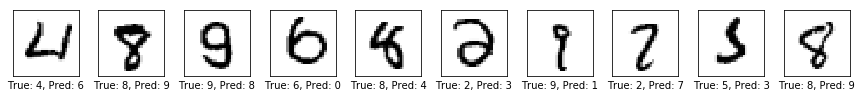

In [46]:
print_test_accuracy(show_example_errors=True)

In [47]:
optimize(num_iterations=9000)

Optimization Iteration:   1901, Training Accuracy:  96.9%
Optimization Iteration:   2001, Training Accuracy:  93.8%
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy:  96.9%
Optimization Iteration:   2301, Training Accuracy: 100.0%
Optimization Iteration:   2401, Training Accuracy:  96.9%
Optimization Iteration:   2501, Training Accuracy:  93.8%
Optimization Iteration:   2601, Training Accuracy:  95.3%
Optimization Iteration:   2701, Training Accuracy:  98.4%
Optimization Iteration:   2801, Training Accuracy:  95.3%
Optimization Iteration:   2901, Training Accuracy:  95.3%
Optimization Iteration:   3001, Training Accuracy:  98.4%
Optimization Iteration:   3101, Training Accuracy:  95.3%
Optimization Iteration:   3201, Training Accuracy:  96.9%
Optimization Iteration:   3301, Training Accuracy:  96.9%
Optimization Iteration:   3401, Training Accuracy:  96.9%
Optimization Iteration:   3501, Training Accuracy:  96.9%
Optimization I

Accuracy on Test Set: 98.7% (9872 / 10000)
Example errors: 


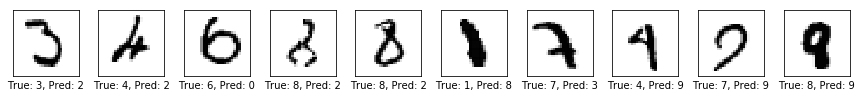

Confusion Matrix
[[ 971    0    1    0    0    1    2    0    3    2]
 [   0 1129    2    0    0    0    1    1    2    0]
 [   1    0 1026    0    0    0    0    1    4    0]
 [   0    0    2 1001    0    4    0    1    2    0]
 [   0    0    3    1  969    0    1    0    1    7]
 [   1    0    0    3    0  884    1    0    0    3]
 [   3    2    0    1    1    5  946    0    0    0]
 [   0    1   17    2    0    0    0 1001    1    6]
 [   2    0    7    3    2    1    0    2  954    3]
 [   1    3    1    4    5    3    0    1    0  991]]


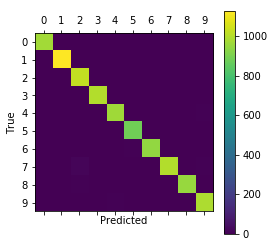

In [48]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [62]:
def plot_conv_weights(weights, input_channel=0):
    w = sess.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = w[:, :, input_channel, 1]
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
            
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [63]:
def plot_conv_layer(layer, image):
    feed_dict = {x:[image]}
    values = sess.run(layer, feed_dict=feed_dict)
    num_filters = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = values[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='binary')
            
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

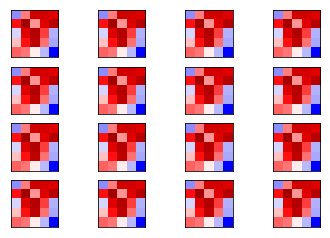

In [64]:
plot_conv_weights(weights=weight_conv1)

In [69]:
def plot_image(image):
    plt.imshow(image.reshape(img_size, img_size), interpolation='nearest', cmap='binary')
    plt.show()

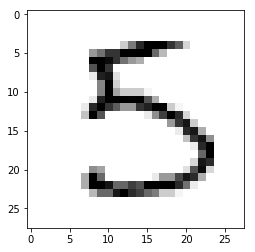

In [70]:
image1 = data.test.images[15]
plot_image(image1)

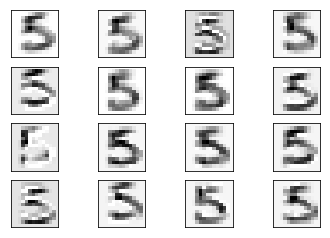

In [72]:
plot_conv_layer(layer=layer_conv1, image=image1)

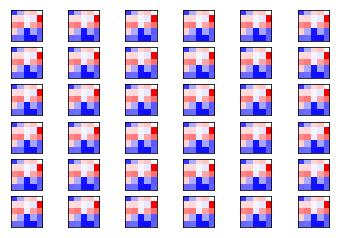

In [73]:
plot_conv_weights(weights=weight_conv2, input_channel=15)

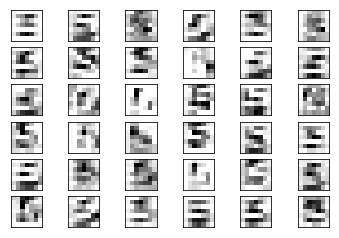

In [74]:
plot_conv_layer(layer=layer_conv2, image=image1)